In [1]:
import os
import math
import numpy as np
import tensorflow as tf
import cv2

slim = tf.contrib.slim
from tensorflow.contrib.slim.python.slim import queues

/home/delia/miniconda3/envs/tensorflow/lib/python3.4/importlib/_bootstrap.py:321: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  return f(*args, **kwds)


Instructions for updating:
Use the retry module or similar alternatives.


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.cm as mpcm

In [3]:
import sys
sys.path.append('../')

In [4]:
from datasets import dataset_factory
from nets import nets_factory
from preprocessing import preprocessing_factory

In [5]:
isess = tf.InteractiveSession()

## Some drawing routines

In [82]:
def colors_subselect(colors, num_classes=21):
    dt = len(colors) // num_classes
    sub_colors = []
    for i in range(num_classes):
        color = colors[i*dt]
        if isinstance(color[0], float):
            sub_colors.append([int(c * 255) for c in color])
        else:
            sub_colors.append([c for c in color])
    return sub_colors

def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """Draw a collection of lines on an image.
    """
    for line in lines:
        for x1, y1, x2, y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)
            
def draw_rectangle(img, p1, p2, color=[255, 0, 0], thickness=2):
    cv2.rectangle(img, p1[::-1], p2[::-1], color, thickness)
    
    
def draw_bbox(img, bbox, shape, label, color=[255, 0, 0], thickness=2):
    p1 = (int(bbox[0] * shape[0]), int(bbox[1] * shape[1]))
    p2 = (int(bbox[2] * shape[0]), int(bbox[3] * shape[1]))
    cv2.rectangle(img, p1[::-1], p2[::-1], color, thickness)
    p1 = (p1[0]+15, p1[1])
    cv2.putText(img, str(label), p1[::-1], cv2.FONT_HERSHEY_DUPLEX, 0.5, color, 1)


def bboxes_draw_on_img(img, classes, scores, bboxes, colors, thickness=2):
    shape = img.shape
    for i in range(bboxes.shape[0]):
        bbox = bboxes[i]
        color = colors[classes[i]]
        # Draw bounding box...
        p1 = (int(bbox[0] * shape[0]), int(bbox[1] * shape[1]))
        p2 = (int(bbox[2] * shape[0]), int(bbox[3] * shape[1]))
        cv2.rectangle(img, p1[::-1], p2[::-1], color, thickness)
        # Draw text...
        
        voc2007_classes = ['none',
            'aeroplane',
            'bicycle',
            'bird',
            'boat',
            'bottle',
            'bus',
            'car',
            'cat',
            'chair',
            'cow',
            'diningtable',
            'dog',
            'horse',
            'motorbike',
            'person',
            'pottedplant',
            'sheep',
            'sofa',
            'train',
            'tvmonitor']

        classes_names = [voc2007_classes[i] for i in classes]
        print(classes_names)
        print(classes)

        s = '%s/%.3f' % (classes_names[i], scores[i])
        p1 = (p1[0]-5, p1[1])
        cv2.putText(img, s, p1[::-1], cv2.FONT_HERSHEY_DUPLEX, 0.4, color, 1)


In [7]:
colors = colors_subselect(mpcm.plasma.colors, num_classes=21)
colors_tableau = [(255, 255, 255), (31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
                 (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
                 (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
                 (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
                 (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]

## Pascal VOC dataset

Check the Pascal VOC pipeline and associated TFRecords files.

DATASET_DIR=./VOC2007/test/
OUTPUT_DIR=./tfrecords
python tf_convert_data.py \
    --dataset_name=pascalvoc \
    --dataset_dir=${DATASET_DIR} \
    --output_name=voc_2007_train \
    --output_dir=${OUTPUT_DIR}

In [8]:
from datasets import pascalvoc_2007
from datasets import pascalvoc_2012

DATASET_DIR = '../tfrecords'
SPLIT_NAME = 'test'
BATCH_SIZE = 16

# Dataset provider loading data from the dataset.
dataset = pascalvoc_2007.get_split(SPLIT_NAME, DATASET_DIR)
provider = slim.dataset_data_provider.DatasetDataProvider(dataset, 
                                                          shuffle=False,
#                                                           num_epochs=1,
                                                          common_queue_capacity=2 * BATCH_SIZE,
                                                          common_queue_min=BATCH_SIZE)
[image, shape, bboxes, labels] = provider.get(['image', 'shape', 'object/bbox', 'object/label'])
print('Dataset:', dataset.data_sources, '|', dataset.num_samples)

Dataset: ../tfrecords/voc_2007_test_*.tfrecord | 4952


In [9]:
print(image)

Tensor("case/cond/Merge:0", shape=(?, ?, 3), dtype=uint8)


In [10]:
# images = tf.train.batch(
#                 [image_crop],
#                 batch_size=BATCH_SIZE,
#                 num_threads=1,
#                 capacity=5 * BATCH_SIZE)

In [11]:
# Problem: image shape is not fully defined => random crop with deterministic size.
xy = tf.random_uniform((2, ), minval=0, maxval=shape[0] // 3, dtype=tf.int64)
image_crop = tf.slice(image, [0, 0, 0], [250, 250, 3])

print('Original vs crop:', image.get_shape(), image_crop.get_shape())

Original vs crop: (?, ?, 3) (250, 250, 3)


In [12]:
# with queues.QueueRunners(sess):
# Start populating queues.
coord = tf.train.Coordinator()
threads = tf.train.start_queue_runners(coord=coord)

In [13]:
# Draw groundtruth bounding boxes using TF routine.
image_bboxes = tf.squeeze(tf.image.draw_bounding_boxes(tf.expand_dims(tf.to_float(image) / 255., 0), 
                                                       tf.expand_dims(bboxes, 0)))

Image shape: (500, 375, 3) [500 375   3]
Bounding boxes: [[0.068      0.00533333 1.         0.90933335]
 [0.258      0.088      0.644      0.264     ]
 [0.264      0.03733333 0.63       0.14933333]
 [0.286      0.24       0.498      0.312     ]]
Labels: [15 15 15 15]


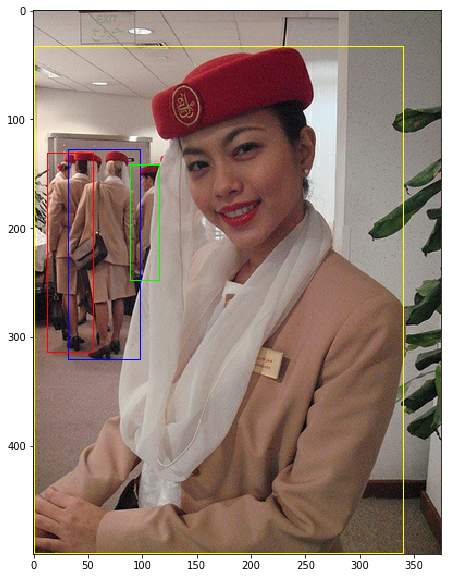

In [63]:
# Eval and display the image + bboxes.
rimg, rshape, rbboxes, rlabels = isess.run([image_bboxes, shape, bboxes, labels])

print('Image shape:', rimg.shape, rshape)
print('Bounding boxes:', rbboxes)
print('Labels:', rlabels)

fig = plt.figure(figsize = (10,10))
plt.imshow(rimg)

## Test SSD-300 model using TFRecords pipeline

Restore model and test it on some random images coming from Pascal TFRecords.

In [71]:
from nets import ssd_vgg_300
from nets import ssd_vgg_512
from nets import ssd_common
from nets import np_methods
import tf_extended as tfe

from preprocessing import ssd_vgg_preprocessing

ckpt_filename = '../checkpoints/ssd_300_vgg.ckpt'
# ckpt_filename = '/media/paul/DataExt4/PascalVOC/training/ckpts/SSD_512x512_ft/ssd_512_vgg.ckpt'
# ckpt_filename = '/home/paul/Development/Research/SSD-Tensorflow/logs/ssd_300_vgg_2/model.ckpt-148624'

In [83]:
# SSD object.
reuse = True if 'ssd' in locals() else None
params = ssd_vgg_300.SSDNet.default_params
ssd = ssd_vgg_300.SSDNet(params)

# Image pre-processimg
out_shape = ssd.params.img_shape
image_pre, labels_pre, bboxes_pre, bbox_img = \
    ssd_vgg_preprocessing.preprocess_for_eval(image, labels, bboxes, out_shape, 
                                              resize=ssd_vgg_preprocessing.Resize.CENTRAL_CROP)
image_4d = tf.expand_dims(image_pre, 0)

# SSD construction.
with slim.arg_scope(ssd.arg_scope(weight_decay=0.0005)):
    predictions, localisations, logits, end_points = ssd.net(image_4d, is_training=False, reuse=reuse)
    
# SSD default anchor boxes.
img_shape = out_shape
layers_anchors = ssd.anchors(img_shape, dtype=np.float32)

In [73]:
print(predictions[0])
print(predictions[0])

Tensor("ssd_300_vgg_2/softmax/Reshape_1:0", shape=(1, 38, 38, 4, 21), dtype=float32)
Tensor("ssd_300_vgg_2/softmax/Reshape_1:0", shape=(1, 38, 38, 4, 21), dtype=float32)


In [84]:
for k in sorted(end_points.keys()):
    print(k, end_points[k].get_shape())

block1 (1, 300, 300, 64)
block10 (1, 3, 3, 256)
block11 (1, 1, 1, 256)
block2 (1, 150, 150, 128)
block3 (1, 75, 75, 256)
block4 (1, 38, 38, 512)
block5 (1, 19, 19, 512)
block6 (1, 19, 19, 1024)
block7 (1, 19, 19, 1024)
block8 (1, 10, 10, 512)
block9 (1, 5, 5, 256)


In [85]:
# Targets encoding.
target_labels, target_localizations, target_scores = \
    ssd_common.tf_ssd_bboxes_encode(labels, bboxes_pre, layers_anchors, 
                                    num_classes=params.num_classes, no_annotation_label=params.no_annotation_label)

In [86]:
nms_threshold = 0.5

# Output decoding.
localisations = ssd.bboxes_decode(localisations, layers_anchors)
tclasses, tscores, tbboxes = ssd_common.tf_ssd_bboxes_select_all_classes(predictions, localisations)
tclasses, tscores, tbboxes = tfe.bboxes.bboxes_sort_all_classes(tclasses, tscores, tbboxes, top_k=200)
tscores, tbboxes = tfe.bboxes.bboxes_nms_batch(tscores, tbboxes, nms_threshold=0.3)

In [87]:
print((tscores))
print((tbboxes))
print((tclasses))

#tf.Print(tclasses)

Tensor("bboxes_nms_batch_2/map/TensorArrayStack/TensorArrayGatherV3:0", shape=(1, 200), dtype=float32)
Tensor("bboxes_nms_batch_2/map/TensorArrayStack_1/TensorArrayGatherV3:0", shape=(1, 200, 4), dtype=float32)
Tensor("bboxes_sort_2/map/TensorArrayStack/TensorArrayGatherV3:0", shape=(1, 200), dtype=int64)


In [88]:
# Initialize variables.
init_op = tf.global_variables_initializer()
isess.run(init_op)
# Restore SSD model.
saver = tf.train.Saver()
saver.restore(isess, ckpt_filename)

INFO:tensorflow:Restoring parameters from ../checkpoints/ssd_300_vgg.ckpt


In [89]:
# Run model.
[rimg, rpredictions, rlocalisations, rclasses, rscores, rbboxes, glabels, gbboxes, rbbox_img, rt_labels, rt_localizations, rt_scores] = \
    isess.run([image_4d, predictions, localisations, tclasses, tscores, tbboxes,
               labels, bboxes_pre, bbox_img, 
               target_labels, target_localizations, target_scores])

In [90]:
def bboxes_select(classes, scores, bboxes, threshold=0.1):
    """Sort bounding boxes by decreasing order and keep only the top_k
    """
    mask = scores > threshold
    classes = classes[mask]
    scores = scores[mask]
    bboxes = bboxes[mask]
    return classes, scores, bboxes

print(rclasses, rscores)
print(rscores.shape)

rclasses, rscores, rbboxes = bboxes_select(rclasses, rscores, rbboxes, 0.1)
# print(list(zip(rclasses, rscores)))
# print(rbboxes)

[[15  9  9 11  9 11  9 11 11  9 11  9  9 11 11  9 11 11  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0]] [[0.9158978  0.789603   0.74155235 0.72906035 0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.     

In [30]:
# # Compute classes and bboxes from the net outputs.
# rclasses, rscores, rbboxes,_,_ = ssd_common.ssd_bboxes_select(rpredictions, rlocalisations, layers_anchors,
#                                                                threshold=0.3, img_shape=img_shape, 
#                                                                num_classes=21, decode=True)
# rbboxes = ssd_common.bboxes_clip(rbbox_img, rbboxes)
# rclasses, rscores, rbboxes = ssd_common.bboxes_sort(rclasses, rscores, rbboxes, top_k=400, priority_inside=False)
# rclasses, rscores, rbboxes = ssd_common.bboxes_nms(rclasses, rscores, rbboxes, threshold=0.3)

AttributeError: 'module' object has no attribute 'ssd_bboxes_select'

['person', 'chair', 'chair', 'diningtable']
[15  9  9 11]
['person', 'chair', 'chair', 'diningtable']
[15  9  9 11]
['person', 'chair', 'chair', 'diningtable']
[15  9  9 11]
['person', 'chair', 'chair', 'diningtable']
[15  9  9 11]
Labels / scores: [(15, 0.9158978), (9, 0.789603), (9, 0.74155235), (11, 0.72906035)]
Grountruth labels: [11, 9, 9, 9, 9, 15]
[[ 0.6133334   0.31333333  1.1266667   1.2333333 ]
 [ 0.53333336  0.54        0.63666666  0.77      ]
 [ 0.5733333   0.20666666  1.09        0.5466667 ]
 [ 0.64666665  0.27        1.1233333   0.64      ]
 [ 0.7866667   0.63666666  1.1266667   1.1233333 ]
 [ 0.06333332 -0.06        1.0366666   0.20333333]]
[[0.06512669 0.00124374 0.9771539  0.19550654]
 [0.52155554 0.54040337 0.6388334  0.7582333 ]
 [0.5736857  0.2231051  1.000303   0.4525585 ]
 [0.61233336 0.27918035 1.0114751  0.95629126]]


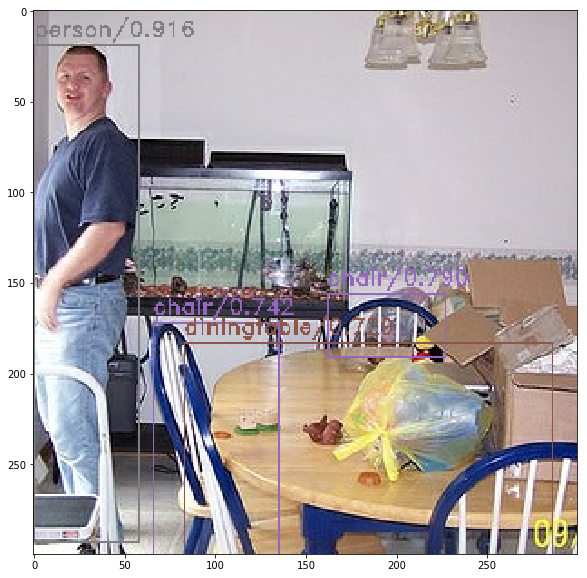

In [92]:
# Draw bboxes
img_bboxes = np.copy(ssd_vgg_preprocessing.np_image_unwhitened(rimg[0]))
bboxes_draw_on_img(img_bboxes, rclasses, rscores, rbboxes, colors_tableau, thickness=1)
# bboxes_draw_on_img(img_bboxes, glabels, np.zeros_like(glabels), gbboxes, colors_tableau, thickness=1)
# bboxes_draw_on_img(img_bboxes, test_labels, test_scores, test_bboxes, colors_tableau, thickness=1)

print('Labels / scores:', list(zip(rclasses, rscores)))
print('Grountruth labels:', list(glabels))
print(gbboxes)
print(rbboxes)

fig = plt.figure(figsize = (10,10))
plt.imshow(img_bboxes)

In [42]:
import tf_extended as tfe

isess.run(tfe.bboxes.bboxes_jaccard(gbboxes[0], rbboxes))

array([0.7295986], dtype=float32)

In [43]:
test_bboxes = []
test_labels = []
test_scores = []
for i in range(0, 3):
    yref, xref, href, wref = layers_anchors[i]
    ymin = yref - href / 2.
    xmin = xref - wref / 2.
    ymax = yref + href / 2.
    xmax = xref + wref / 2.
    bb = np.stack([ymin, xmin, ymax, xmax], axis=-1)
    
    idx = yref.shape[0] // 2
    idx = np.random.randint(yref.shape[0])
#     print(bb[idx, idx].shape)
    test_bboxes.append(bb[idx, idx])
    test_labels.append(np.ones(href.shape, dtype=np.int64) * i)
    test_scores.append(np.ones(href.shape))

test_bboxes = np.concatenate(test_bboxes)
test_labels = np.concatenate(test_labels)
test_scores = np.concatenate(test_scores)

print(test_bboxes.shape)
print(test_labels.shape)
print(test_scores.shape)


(16, 4)
(16,)
(16,)


In [96]:
rt_labels, rt_localizations, rt_scores
for i in range(len(rt_labels)):
    print(rt_labels[i].shape)
    idxes = np.where(rt_labels[i] > 0)
#     idxes = np.where(rt_scores[i] > 0.)
    print(idxes)
    print(rt_localizations[i][idxes])
    print(list(zip(rt_labels[i][idxes], rt_scores[i][idxes])))
    print()

(38, 38, 4)
(array([ 0,  0,  0, ..., 37, 37, 37]), array([ 0,  1,  2, ..., 37, 37, 37]), array([1, 1, 1, ..., 1, 2, 3]))
[[  5.6927495   52.3733       4.7192764   11.255807  ]
 [  3.09035     52.3733       4.7192764   11.255807  ]
 [  0.48794955  52.3733       4.7192764   11.255807  ]
 ...
 [-11.710801    -4.228896     7.7900705    5.9969015 ]
 [-12.121831    -8.754647     7.962553     9.635119  ]
 [-24.243662    -4.3773236   11.428289     6.1693835 ]]
[(15, 0.00047444162), (15, 0.00047444168), (15, 0.00047444168), (15, 0.00047444162), (15, 0.00047444168), (15, 0.00047444162), (15, 0.0003760861), (15, 0.00025259834), (15, 0.00012914106), (15, 5.714331e-06), (15, 0.003136273), (15, 0.01083169), (15, 0.00053670886), (15, 0.0049826084), (15, 0.0031362732), (15, 0.010831691), (15, 0.00053670886), (15, 0.004982608), (15, 0.0031362732), (15, 0.010831691), (15, 0.00053670886), (15, 0.004982608), (15, 0.0031362728), (15, 0.01083169), (15, 0.0005367088), (15, 0.004982608), (15, 0.0031362732), (

In [98]:
 #fig = plt.figure(figsize = (8,8))
 #plt.imshow(ssd_vgg_preprocessing.np_image_unwhitened(rimg[0]))
 #print('Ground truth labels: ', rlabels)

In [99]:
# Request threads to stop. Just to avoid error messages
coord.request_stop()
coord.join(threads)

In [ ]:
PleaseStopHere;

## Test SSD-300 model using sample images

Restore model and test it on some sample images.

In [106]:
# Input placeholder.
net_shape = (300, 300)
img_input = tf.placeholder(tf.uint8, shape=(None, None, 3))
image_pre, labels_pre, bboxes_pre, bbox_img = ssd_vgg_preprocessing.preprocess_for_eval(
    img_input, labels, None, net_shape, resize=ssd_vgg_preprocessing.Resize.PAD_AND_RESIZE)
image_4d = tf.expand_dims(image_pre, 0)

# Re-define the model
reuse = True if 'ssd' in locals() else None
with slim.arg_scope(ssd.arg_scope(weight_decay=0.0005)):
    predictions, localisations, logits, end_points = ssd.net(image_4d, is_training=False, reuse=reuse)

In [105]:
image_4d

<tf.Tensor 'ExpandDims_10:0' shape=(1, 300, 300, 3) dtype=float32>

In [ ]:
#rimg, rpredictions, rlocalisations, rbbox_img = isess.run([image_4d, predictions, localisations, bbox_img],
#                                                              feed_dict={img_input: img})
#print(rpredictions)
#select_threshold=0.5
#rclasses, rscores, rbboxes= np_methods.ssd_bboxes_select(
#            rpredictions, rlocalisations, layers_anchors,
#            select_threshold=select_threshold, img_shape=net_shape, num_classes=21, decode=True)


In [49]:
# Main processing routine.
def process_image(img, select_threshold=0.5, nms_threshold=0.35, net_shape=(300, 300)):
    # Run SSD network.
    rimg, rpredictions, rlocalisations, rbbox_img = isess.run([image_4d, predictions, localisations, bbox_img],
                                                              feed_dict={img_input: img})
    # Compute classes and bboxes from the net outputs.
    #rclasses, rscores, rbboxes, rlayers, ridxes = tfe.bboxes.ssd_bboxes_select(
    #        rpredictions, rlocalisations, layers_anchors,
    #        threshold=select_threshold, img_shape=net_shape, num_classes=21, decode=True)
    rclasses, rscores, rbboxes= np_methods.ssd_bboxes_select(
            rpredictions, rlocalisations, layers_anchors,
            select_threshold=select_threshold, img_shape=net_shape, num_classes=21, decode=True)
#     print(list(zip(classes, scores)))
#     print(rlayers)
#     print(ridxes)
    
    rbboxes = np_methods.bboxes_clip(rbbox_img, rbboxes)
    rclasses, rscores, rbboxes = np_methods.bboxes_sort(rclasses, rscores, rbboxes, 
                                                        top_k=400)
    rclasses, rscores, rbboxes = np_methods.bboxes_nms(rclasses, rscores, rbboxes, nms_threshold=nms_threshold)
    # Resize bboxes to original image shape.
    rbboxes = np_methods.bboxes_resize(rbbox_img, rbboxes)
    return rclasses, rscores, rbboxes
    

['137.jpg', '223.jpg', '3.jpg', '418.jpg', '521.jpg', '631.jpg']
../demo/nyuv2/418.jpg
['car', 'person', 'person']
[ 7 15 15]
['car', 'person', 'person']
[ 7 15 15]
['car', 'person', 'person']
[ 7 15 15]
['bicycle', 'person']
[ 2 15]
['bicycle', 'person']
[ 2 15]
['car']
[7]
['person', 'person']
[15 15]
['person', 'person']
[15 15]
['car']
[7]


OutOfRangeError: FIFOQueue '_2_parallel_read/common_queue' is closed and has insufficient elements (requested 1, current size 0)
	 [[Node: parallel_read/common_queue_Dequeue = QueueDequeueV2[component_types=[DT_STRING, DT_STRING], timeout_ms=-1, _device="/job:localhost/replica:0/task:0/device:CPU:0"](parallel_read/common_queue)]]

Caused by op 'parallel_read/common_queue_Dequeue', defined at:
  File "/home/delia/miniconda3/envs/tensorflow/lib/python3.4/runpy.py", line 170, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/delia/miniconda3/envs/tensorflow/lib/python3.4/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/delia/miniconda3/envs/tensorflow/lib/python3.4/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/delia/miniconda3/envs/tensorflow/lib/python3.4/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/delia/miniconda3/envs/tensorflow/lib/python3.4/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/home/delia/miniconda3/envs/tensorflow/lib/python3.4/site-packages/tornado/platform/asyncio.py", line 127, in start
    self.asyncio_loop.run_forever()
  File "/home/delia/miniconda3/envs/tensorflow/lib/python3.4/asyncio/base_events.py", line 331, in run_forever
    self._run_once()
  File "/home/delia/miniconda3/envs/tensorflow/lib/python3.4/asyncio/base_events.py", line 1295, in _run_once
    handle._run()
  File "/home/delia/miniconda3/envs/tensorflow/lib/python3.4/asyncio/events.py", line 125, in _run
    self._callback(*self._args)
  File "/home/delia/miniconda3/envs/tensorflow/lib/python3.4/site-packages/tornado/platform/asyncio.py", line 117, in _handle_events
    handler_func(fileobj, events)
  File "/home/delia/miniconda3/envs/tensorflow/lib/python3.4/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/delia/miniconda3/envs/tensorflow/lib/python3.4/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/home/delia/miniconda3/envs/tensorflow/lib/python3.4/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/delia/miniconda3/envs/tensorflow/lib/python3.4/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/home/delia/miniconda3/envs/tensorflow/lib/python3.4/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/delia/miniconda3/envs/tensorflow/lib/python3.4/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/delia/miniconda3/envs/tensorflow/lib/python3.4/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/delia/miniconda3/envs/tensorflow/lib/python3.4/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/delia/miniconda3/envs/tensorflow/lib/python3.4/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/delia/miniconda3/envs/tensorflow/lib/python3.4/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/delia/miniconda3/envs/tensorflow/lib/python3.4/site-packages/IPython/core/interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/delia/miniconda3/envs/tensorflow/lib/python3.4/site-packages/IPython/core/interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/delia/miniconda3/envs/tensorflow/lib/python3.4/site-packages/IPython/core/interactiveshell.py", line 2903, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/delia/miniconda3/envs/tensorflow/lib/python3.4/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-8-02f6ae0d3ecb>", line 14, in <module>
    common_queue_min=BATCH_SIZE)
  File "/home/delia/miniconda3/envs/tensorflow/lib/python3.4/site-packages/tensorflow/contrib/slim/python/slim/data/dataset_data_provider.py", line 96, in __init__
    scope=scope)
  File "/home/delia/miniconda3/envs/tensorflow/lib/python3.4/site-packages/tensorflow/contrib/slim/python/slim/data/parallel_reader.py", line 262, in parallel_read
    reader_kwargs=reader_kwargs).read(filename_queue)
  File "/home/delia/miniconda3/envs/tensorflow/lib/python3.4/site-packages/tensorflow/contrib/slim/python/slim/data/parallel_reader.py", line 131, in read
    return self._common_queue.dequeue(name=name)
  File "/home/delia/miniconda3/envs/tensorflow/lib/python3.4/site-packages/tensorflow/python/ops/data_flow_ops.py", line 440, in dequeue
    self._queue_ref, self._dtypes, name=name)
  File "/home/delia/miniconda3/envs/tensorflow/lib/python3.4/site-packages/tensorflow/python/ops/gen_data_flow_ops.py", line 3730, in queue_dequeue_v2
    timeout_ms=timeout_ms, name=name)
  File "/home/delia/miniconda3/envs/tensorflow/lib/python3.4/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/delia/miniconda3/envs/tensorflow/lib/python3.4/site-packages/tensorflow/python/framework/ops.py", line 3290, in create_op
    op_def=op_def)
  File "/home/delia/miniconda3/envs/tensorflow/lib/python3.4/site-packages/tensorflow/python/framework/ops.py", line 1654, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

OutOfRangeError (see above for traceback): FIFOQueue '_2_parallel_read/common_queue' is closed and has insufficient elements (requested 1, current size 0)
	 [[Node: parallel_read/common_queue_Dequeue = QueueDequeueV2[component_types=[DT_STRING, DT_STRING], timeout_ms=-1, _device="/job:localhost/replica:0/task:0/device:CPU:0"](parallel_read/common_queue)]]


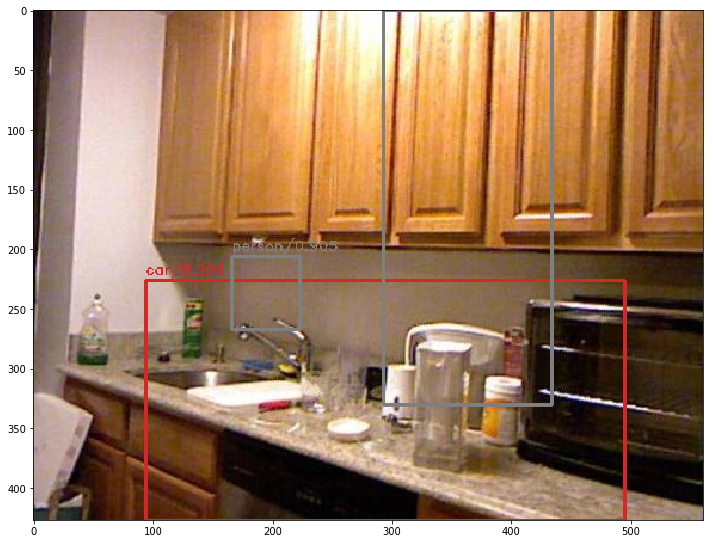

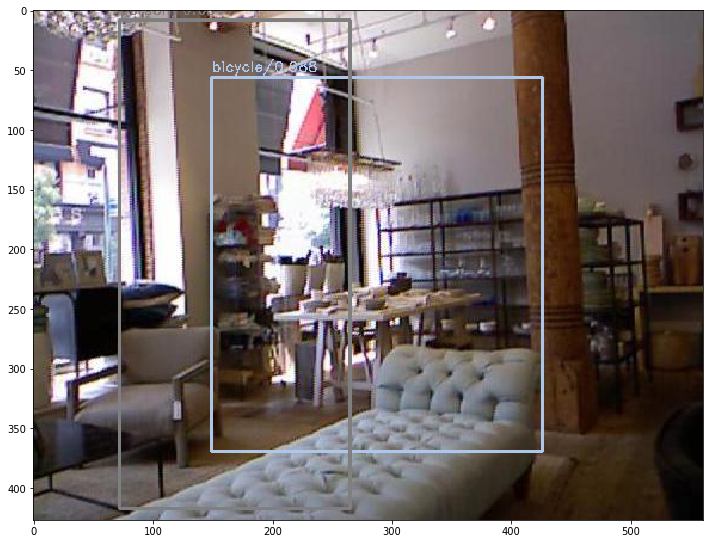

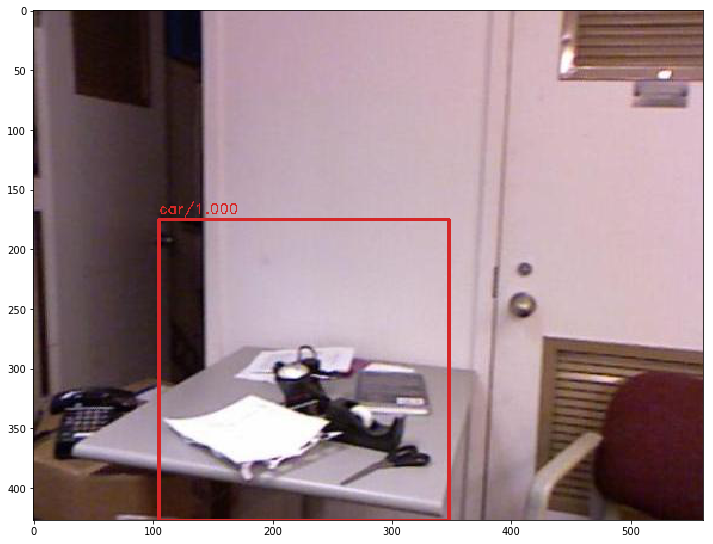

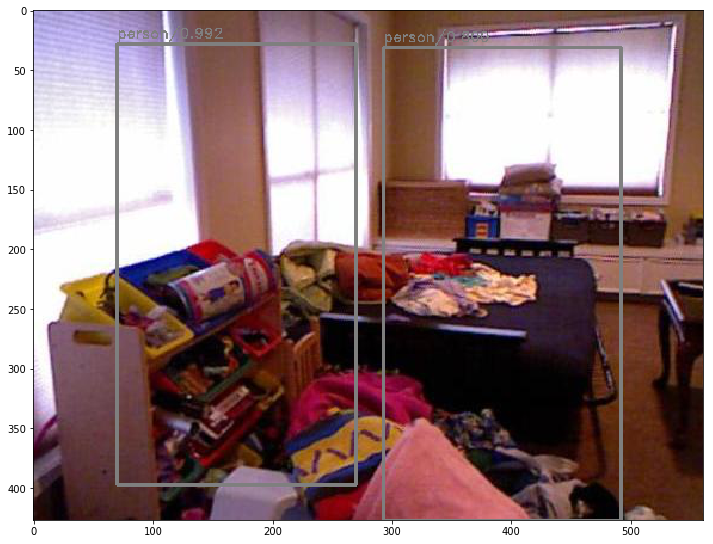

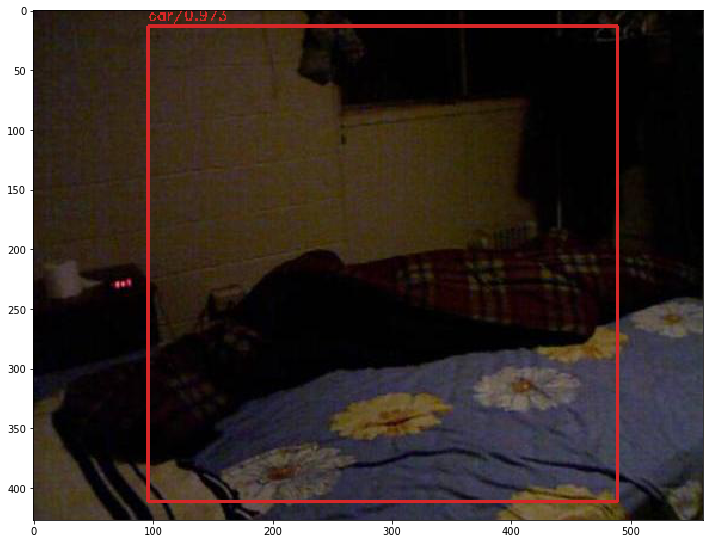

In [101]:
# Test on demo images.
path = '../demo/nyuv2/'
image_names = sorted(os.listdir(path))
print(image_names)
print(path + image_names[-3])
for image_name in image_names:
    img = mpimg.imread(path + image_name)

    rclasses, rscores, rbboxes =  process_image(img)
    # Draw results.
    img_bboxes = np.copy(img)
    bboxes_draw_on_img(img_bboxes, rclasses, rscores, rbboxes, colors_tableau, thickness=2)

    fig = plt.figure(figsize = (12, 12))
    plt.imshow(img_bboxes)

In [ ]:
idxes = np.where(inside)
rscores[idxes]

## Some TensorFlow tests...

In [47]:
a = tf.constant([[5.0, 2], [5.0, 2]])
b = tf.constant([5.0, 2])
c = a * b
d = tf.nn.l2_normalize(a, dim=1)
# We can just use 'c.eval()' without passing 'sess'
print(d.eval())

Instructions for updating:
dim is deprecated, use axis instead
[[0.9284767  0.37139067]
 [0.9284767  0.37139067]]


## A few tests on Caffe model files...

In [ ]:
from pprint import pprint

import caffe
import numpy as np
from caffe.proto import caffe_pb2

caffe_filename = '/media/paul/DataExt4/PascalVOC/training/ckpts/SSD_300x300_ft/ssd_300_vgg.caffemodel'
caffe_filename = '/media/paul/DataExt4/PascalVOC/training/ckpts/SSD_512x512_ft/ssd_512_vgg.caffemodel'

caffemodel_params = caffe_pb2.NetParameter()
caffemodel_str = open(caffe_filename, 'rb').read()
caffemodel_params.ParseFromString(caffemodel_str)

In [ ]:
layers = caffemodel_params.layer
names = [(i, l.name, l.type, l.blobs[0].shape.dim if len(l.blobs) else 0) for i, l in enumerate(layers)]
pprint(names)

In [ ]:
idx = 2
layer = layers[idx]
print(layer.type)
a = np.array(layer.blobs[0].data)
s = layer.blobs[0].shape.dim
print(s, 38*38)
# print(a)

In [ ]:
from nets import caffe_scope

In [ ]:
csc = caffe_scope.CaffeScope()

In [ ]:
d = {}
d[csc.conv_biases_init] = 0
d[csc.conv_biases_init] += 1

In [ ]:
min_dim = 300
mbox_source_layers = ['conv4_3', 'fc7', 'conv6_2', 'conv7_2', 'conv8_2', 'conv9_2']
min_ratio = 15
max_ratio = 90
step = int(math.floor((max_ratio - min_ratio) / (len(mbox_source_layers) - 2)))
min_sizes = []
max_sizes = []
for ratio in range(min_ratio, max_ratio + 1, step):
    min_sizes.append(min_dim * ratio / 100.)
    max_sizes.append(min_dim * (ratio + step) / 100.)
min_sizes = [min_dim * 7 / 100.] + min_sizes
max_sizes = [min_dim * 15 / 100.] + max_sizes

In [ ]:
print(min_sizes)
print(max_sizes)

In [ ]:
feat_shapes=[(38, 38), (19, 19), (10, 10), (5, 5), (3, 3), (1, 1)]

In [ ]:
steps = [8, 16, 32, 64, 100, 300]
offset = 0.5

In [ ]:
for i in range(len(steps)):
    print((feat_shapes[i][0] - offset) * steps[i] / 300, (feat_shapes[i][0] - offset) / feat_shapes[i][0])

In [ ]:
min_dim = 512
# conv4_3 ==> 64 x 64
# fc7 ==> 32 x 32
# conv6_2 ==> 16 x 16
# conv7_2 ==> 8 x 8
# conv8_2 ==> 4 x 4
# conv9_2 ==> 2 x 2
# conv10_2 ==> 1 x 1
mbox_source_layers = ['conv4_3', 'fc7', 'conv6_2', 'conv7_2', 'conv8_2', 'conv9_2', 'conv10_2']
# in percent %
min_ratio = 10
max_ratio = 90
step = int(math.floor((max_ratio - min_ratio) / (len(mbox_source_layers) - 2)))
min_sizes = []
max_sizes = []
for ratio in range(min_ratio, max_ratio + 1, step):
  min_sizes.append(min_dim * ratio / 100.)
  max_sizes.append(min_dim * (ratio + step) / 100.)
min_sizes = [min_dim * 4 / 100.] + min_sizes
max_sizes = [min_dim * 10 / 100.] + max_sizes
steps = [8, 16, 32, 64, 128, 256, 512]

In [ ]:
print(min_sizes)
print(max_sizes)

In [ ]:
pprint(list(zip(min_sizes, max_sizes)))